In [1]:
import markovianSBM
from markovianSBM.SBM import SBM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats
import os

## 1) Collaborative filtering

We observe fully the graph until time $m$. We consider some node $n>m$. We observe the edges connecting node $n$ and the nodes belonging to $\mathcal E = \{m-nb, \dots , m\}$ for some $nb \in \{ 1, \dots , m-1 \}$ and we want to predict the cluster of the node $n$. 

In [ ]:
lsplugin = []
lsrobust = []
lsoptimal = []
np.random.seed(5)
n = 80
delta = 150
m = 30
K = 4
P = np.array([[0.1, 0.3, 0.5,0.1],[0.45, 0.15, 0.2, 0.2],[0.15, 0.3, 0.1, 0.45 ],[0.25, 0.3, 0.1, 0.35 ]])
Q = np.array([[0.22, 0.48, 0.29, 0.44], [0.48, 0.61 ,0.18, 0.15],  [0.29 , 0.18 ,0.08 ,0.87],  [0.44 ,0.15 ,0.87, 0.27]])
G = SBM(n+delta+1, K, framework='markov', P=P, Q=Q, save_B_matrices=True)
temp = G.X[:m+1,:]
X = temp[:,:m+1]
Ggap = SBM(m+1, K, framework='markov', X=X, P=P, Q=Q, save_B_matrices=True)
Ggap.clusters = G.clusters[:m+1]
ini, gamma, Pbaum, O = Ggap.BaumWelch(m-1,m,0, 150)
Ggap.estimate_parameters()

alpha = Ggap.forward(ini, Ggap.approx_P, O, m-1,m, 0, Ggap.clusters_approx)
beta = Ggap.backward(Ggap.approx_P, O, m-1,m, 0, Ggap.clusters_approx)
for nb in range(2,25):
    lsplugin.append([])
    lsrobust.append([])
    lsoptimal.append([])
    for final_node in range(m+1,n+delta):
        observed_links = G.X[m-nb:m+1,final_node]
        observed_nodes = np.array([i for i in range(m-nb,m+1)])
        robustMAP = Ggap.collaborative_filtering_robustMAP(ini, alpha, beta, O, observed_links, observed_nodes, m, final_node)
        pluginMAP = Ggap.collaborative_filtering_pluginMAP(alpha, beta, observed_links, observed_nodes, m, final_node)
        optimalMAP = Ggap.collaborative_filtering_optimalMAP(alpha, beta, observed_links, observed_nodes, m, final_node)
        if G.clusters[final_node] != pluginMAP:
            lsplugin[-1].append(1)
        else:
            lsplugin[-1].append(0)
        if G.clusters[final_node] != robustMAP:
            lsrobust[-1].append(1)
        else:
            lsrobust[-1].append(0)
        if G.clusters[final_node] != optimalMAP:
            lsoptimal[-1].append(1)
        else:
            lsoptimal[-1].append(0)

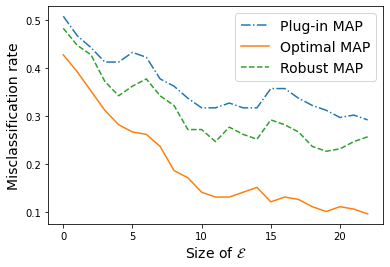

In [ ]:
plt.plot(np.mean(lsplugin,axis=1), linestyle='-.', label='Plug-in MAP')
plt.plot(np.mean(lsoptimal,axis=1), label='Optimal MAP')
plt.plot(np.mean(lsrobust,axis=1), linestyle='--', label='Robust MAP')
plt.legend(fontsize=14)
plt.ylabel('Misclassification rate', fontsize=14)
plt.xlabel("Size of $\mathcal{E}$", fontsize=14)
plt.savefig('collaborative.png',dpi=200)

## 2) Use of the emission probabilities
### a) Understanding of the mistake made by the clustering algorithm

In this first subsection, we show how the study of the emission probabilities learned by the Baum-Welch algorithm can be used to extract relevant information on the clustering algorithm used to recover communities. Typically, we show in our example that the SDP based clustering algorithm used in our paper tends to over-estimate the sizes of the smallest clusters.

In [ ]:
np.random.seed(4)
n = 110
delta = 10
m = 90
K = 4
P = np.array([[0.1, 0.3, 0.5,0.1],[0.45, 0.15, 0.2, 0.2],[0.15, 0.3, 0.1, 0.45 ],[0.25, 0.3, 0.1, 0.35 ]])
Q = np.array([[0.22, 0.48, 0.29, 0.44], [0.48, 0.61 ,0.18, 0.15],  [0.29 , 0.18 ,0.08 ,0.87],  [0.44 ,0.15 ,0.87, 0.27]])
G = SBM(n+delta+1, K, framework='markov', P=P, Q=Q, save_B_matrices=True)
X = G.adjacency_BaumWelch(m, n, delta)
Ggap = SBM(m+delta+2, K, framework='markov', X=X, save_B_matrices=True)
ini, gamma, P, O = Ggap.BaumWelch(m,n, delta, 10)

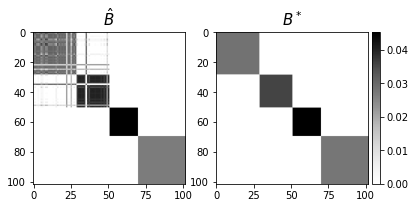

In [ ]:
Ggap.clusters = np.concatenate((G.clusters[:m+1],G.clusters[n:]))
for i in range(m+1):
    Ggap.B[i,:m+1] = G.B[i,:m+1]
    Ggap.B[:m+1,i] = G.B[i,:m+1]
for i in range(delta+1):  
    Ggap.B[m+i+1,m+1:] = G.B[n+i,n:n+delta+1]
    Ggap.B[m+1:,m+i+1] = G.B[n:n+delta+1,n+i]
    Ggap.B[m+i+1,:m+1] = G.B[n+i,:m+1]
    Ggap.B[:m+1,m+i+1] = G.B[:m+1,n+i]
Ggap.visualize_B_matrices()

We show here on the right the matrix $B^* \in \mathbb{R}^{n\times n}$ defined by 

\begin{equation}(*_1)\qquad \forall i,j \in [n], \quad B_{i,j}^*=\left\{
    \begin{array}{ll} \displaystyle
        \frac{1}{m_k}& \mbox{if } i \text{ and } j \text{ belong to the same community } k \in [K] \\
        0 & \text{ otherwise.}
    \end{array}
\right. \end{equation}
where for in $k \in [K]$, $m_k$ is the number of nodes in the cluster $k$.

On the left, we show the solution of the relaxed K-means optimization problem. The clustering algorithm from Verzelen and Giraud that we use perform a rounding step on the columns of this matrix to estimate the communities of the nodes.

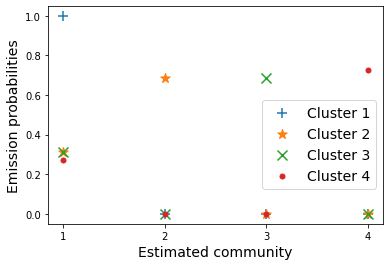

In [ ]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
marks = ['+','*', 'x','.']
for i in range(K):
    ax.scatter([k for k in range(1,Ggap.K+1)], O[i,:], label='Cluster '+str(i+1), marker=marks[i],s=100)
ax.legend(fontsize=14,bbox_to_anchor=(1,0.6))
ax.set_xlabel('Estimated community',fontsize=14)
ax.set_ylabel('Emission probabilities',fontsize=14)
plt.savefig('emission_proba.png',dpi=250)

As previous explained, the clustering algorithm tends to over-estimate the size of the smallest community, namely the community $1$. We recall that the asymptotic repartition of the nodes between the 4 clusters is given by $[0.14,0.22,0.38,0.26]$.

### b) Estimating number of clusters: Simulated data

In [ ]:
np.random.seed(4)
n = 100
delta = 10
m = 90
K = 4
scores = []
P = np.array([[0.1, 0.3, 0.5,0.1],[0.45, 0.15, 0.2, 0.2],[0.15, 0.3, 0.1, 0.45 ],[0.25, 0.3, 0.1, 0.35 ]])
Q = np.array([[0.22, 0.48, 0.29, 0.44], [0.48, 0.61 ,0.18, 0.15],  [0.29 , 0.18 ,0.08 ,0.87],  [0.44 ,0.15 ,0.87, 0.27]])
G = SBM(n+delta+1, K, framework='markov', P=P, Q=Q, save_B_matrices=True)
for K in [2,3,4,5,6,7]:
    Ggap = SBM(G.n, K, framework='markov', X=G.X, save_B_matrices=True)
    Ggap.clusters = [np.random.randint(0,K) for i in range(G.n)]
    ini, gamma, P, O = Ggap.BaumWelch(n-3, n-2, 0, 20, eps = 1e-2, K=K)
    score = np.max(-2*np.eye(K)+O+O.T)
    scores.append(score)

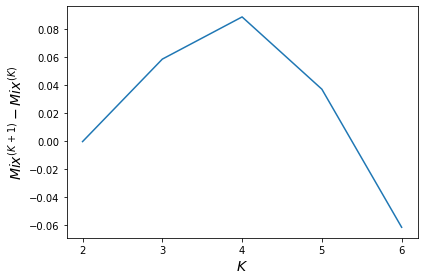

In [ ]:
from matplotlib.ticker import MaxNLocator
ls = []
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for k in range(len(scores)-1):
    ls.append(scores[k+1]-scores[k])
ax.plot([k for k in range(2,7)], ls)
ax.set_ylabel('$Mix^{(K+1)}-Mix^{(K)}$',fontsize=14)
ax.set_xlabel('$K$',fontsize=14)
plt.tight_layout()
plt.savefig('inferring_K.png',dpi=250)

### c) Estimating number of clusters: Football datatset from Networkx

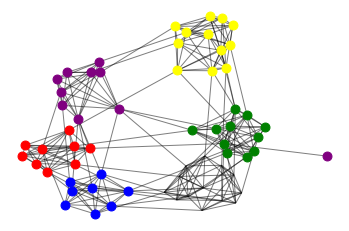

<Figure size 432x288 with 0 Axes>

In [ ]:
import urllib.request as urllib
import io
import zipfile

import matplotlib.pyplot as plt
import networkx as nx

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data
values = nx.get_node_attributes(G,'value')

indices = []
a = list(G.nodes.keys())
NODES = []
for i,el in enumerate(a):
    if values[el] in [0,1,2,3,4,6]:
        indices.append(i)
        NODES.append(el)

    else:
        G.remove_node(el)

coloring = {}
for node in NODES:
    coloring[node] = values[node]

def draw_coloring(G,coloring,colors):
    fig = plt.figure()
    n_colors = len(colors)

    pos = nx.spring_layout(G)
    for i in range(n_colors):
        nx.draw_networkx_nodes(G,pos,[x for x in G.nodes() if coloring[x]==i],node_size=80,node_color=colors[i])
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
        
    plt.axis('off')
    plt.show() 
    return fig
some_colors = ['red','blue','green','yellow','purple', 'black' ]
fig2 = draw_coloring(G,coloring,some_colors)
plt.savefig("Graph.png", format="PNG", dpi=300)

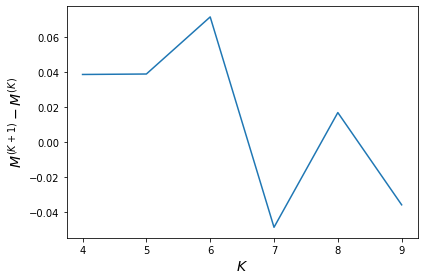

In [ ]:
url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data
values = nx.get_node_attributes(G,'value')

X = nx.adjacency_matrix(G).todense()
a = list(G.nodes.keys())
indices = []
for i,el in enumerate(a):
    if values[el] in [0,1,2,3,4]:
        indices.append(i)
np.random.seed(4)
X= X[indices,:]
X = X[:,indices]
n = X.shape[0]
scores =[]
for K in [4,5,6,7,8,9,10]:
    print(K)
    G = SBM(n, K, framework='markov', X=X, save_B_matrices=False)
    G.clusters = [np.random.randint(0,K) for i in range(G.n)]
    ini, gamma, P, O = G.BaumWelch(n-3, n-2, 0, 20, eps = 1e-2, K=K)
    del G
    score = np.max(-2*np.eye(K)+O+O.T)
    scores.append(score)
    np.save('scores_6.npy',scores)
from matplotlib.ticker import MaxNLocator
ls = []
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for k in range(len(scores)-1):
    ls.append(scores[k+1]-scores[k])
ax.plot([k for k in range(4,10)], ls)
ax.set_ylabel('$M^{(K+1)}-M^{(K)}$',fontsize=14)
ax.set_xlabel('$K$',fontsize=14)
plt.tight_layout()
plt.savefig('inferring_K_Football.png',dpi=250)

# 3) Link Prediction
### a) Plug In approach

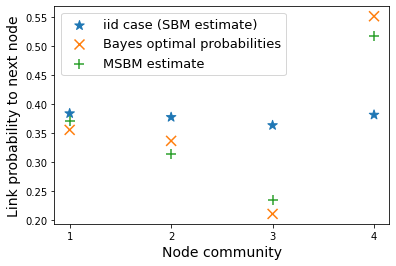

In [ ]:
np.random.seed(5)
n = 180
K = 4
P = np.array([[0.1, 0.3, 0.5,0.1],[0.45, 0.15, 0.2, 0.2],[0.15, 0.3, 0.1, 0.45 ],[0.25, 0.3, 0.1, 0.35 ]])
Q = np.array([[0.22, 0.48, 0.29, 0.44], [0.48, 0.61 ,0.18, 0.15],  [0.29 , 0.18 ,0.08 ,0.87],  [0.44 ,0.15 ,0.87, 0.27]])
G = SBM(n, K, framework='markov', P=P, Q=Q)
G.estimate_partition()
G.estimate_parameters()

gap = np.float('inf')
s,v = np.linalg.eigh(P.T)
invmeas = np.zeros(K)
for i in range(len(s)):
    if abs(s[i]-1)<gap:
        gap = abs(s[i]-1)
        invmeas = v[:,i]
if invmeas[0]<0:
    invmeas *= -1
    invmeas /= np.sum(invmeas)

Piid = np.tile(np.array(invmeas).reshape(1,-1),(K,1))
Giid = SBM(n, K, framework='markov', P=Piid, Q=Q)
Giid.estimate_partition()
Giid.estimate_parameters()

def link_prediction_iid_case():
    link_probas = np.zeros(Giid.K)
    compteur = np.zeros(Giid.K)
    for i in range(n-2):
        link_probas[G.clusters[i]] += np.sum(Giid.P[G.clusters[Giid.n-1],:] * Giid.Q[Giid.clusters[i],:])
        compteur[G.clusters[i]] += 1
    link_probas /= compteur
    return link_probas

def link_prediction_estimates():
    link_probas = np.zeros(G.K)
    compteur = np.zeros(G.K)
    for i in range(n-2):
        link_probas[G.clusters_approx[i]] += np.sum(G.approx_P[G.clusters_approx[G.n-1],:] * G.approx_Q[G.clusters_approx[i],:])
        compteur[G.clusters_approx[i]] += 1
    link_probas /= compteur
    return link_probas
        
def link_prediction_true():
    link_probas = np.zeros(G.K)
    compteur = np.zeros(G.K)
    for i in range(n-1):
        link_probas[G.clusters_approx[i]] += np.sum(G.P[G.clusters_approx[G.n-1],:] * G.Q[G.clusters_approx[i],:])
        compteur[G.clusters_approx[i]] += 1
    link_probas /= compteur
    return link_probas

link_probas_iid_case = link_prediction_iid_case()
link_probas_estimates = link_prediction_estimates()
link_probas_true = link_prediction_true()

from matplotlib.ticker import MaxNLocator
M = 4
m = 0
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ind = np.array([i for i in range(m+1,M+1)])
ax.scatter(ind, link_probas_iid_case[m:M].reshape(-1),marker='*', label='iid case (SBM estimate)',s=100*np.ones(M-m))
ax.scatter(ind, link_probas_true[m:M].reshape(-1),marker='x', label='Bayes optimal probabilities',s=100*np.ones(M-m))
ax.scatter(ind, link_probas_estimates[m:M].reshape(-1), marker='+', label='MSBM estimate',s=100*np.ones(M-m))
ax.set_xlabel('Node community',fontsize=14)
ax.set_ylabel('Link probability to next node', fontsize=14)
ax.legend(fontsize=13,loc=2)
plt.show()

### b) Robust link prediction

In [ ]:
np.random.seed(4)
n = 70
K = 4
P = np.array([[0.1, 0.3, 0.5,0.1],[0.45, 0.15, 0.2, 0.2],[0.15, 0.3, 0.1, 0.45 ],[0.25, 0.3, 0.1, 0.35 ]])
Q = np.array([[0.22, 0.48, 0.29, 0.44], [0.48, 0.61 ,0.18, 0.15],  [0.29 , 0.18 ,0.08 ,0.87],  [0.44 ,0.15 ,0.87, 0.27]])
G = SBM(n, K, framework='markov', P=P, Q=np.log(n)*Q/n)
G.estimate_partition()
G.estimate_parameters()


gap = np.float('inf')
s,v = np.linalg.eigh(P.T)
invmeas = np.zeros(K)
for i in range(len(s)):
    if abs(s[i]-1)<gap:
        gap = abs(s[i]-1)
        invmeas = v[:,i]

if invmeas[0]<0:
    invmeas *= -1
    invmeas /= np.sum(invmeas)

Piid = np.tile(np.array(invmeas).reshape(1,-1),(K,1))

Giid = SBM(n, K, framework='markov', P=Piid, Q=Q)
Giid.estimate_partition()
Giid.estimate_parameters()

def link_prediction_iid_case():
    link_probas = np.zeros(Giid.n)
    compteur = np.zeros(Giid.K)
    for i in range(n-2):
        link_probas[i] += np.sum(Giid.P[G.clusters[Giid.n-1],:] * Giid.Q[Giid.clusters[i],:])
    return link_probas

def link_prediction_plugin():
    link_probas = np.zeros(G.n)
    compteur = np.zeros(G.K)
    for i in range(n-2):
        link_probas[i] += np.sum(G.approx_P[G.clusters_approx[G.n-1],:] * G.approx_Q[G.clusters_approx[i],:])
    return link_probas
        
def link_prediction_robust():
    ini, gamma, P, O = G.BaumWelch(G.n-2,G.n-1, 0 , 40)
    alpha = G.forward(ini, G.approx_P, O, G.n-2, G.n-1, 0, G.clusters_approx)
    beta = G.backward(G.approx_P, O, G.n-2, G.n-1, 0, G.clusters_approx)
    Y = G.clusters_approx
    link_probas = np.zeros(G.n)
    compteur = np.zeros(G.K)
    chi = np.zeros((G.K,G.K))
    for c in range(G.K):
        for cb in range(G.K):
            chi[c,cb] = G.approx_P[c,cb]*O[cb,G.clusters_approx[G.n-1]]
    for i in range(n-2,-1,-1):
        temp = np.zeros((G.K,G.K, G.K))
        for k in range(G.K):
            for ci in range(G.K):
                for cn in range(G.K):
                    temp[ci,cn,k] = alpha[ci,i] * chi[ci,cn] * beta[cn,G.n-1]
            temp[:,:,k] /= np.sum(temp[:,:,k])
        for k in range(G.K):
            for ci in range(G.K):
                for cn in range(G.K):
                    temp[ci,cn,k] *= G.approx_Q[ci,k] * G.approx_P[cn,k]
        link_probas[i] = np.sum(temp)
        chinew = np.zeros((G.K,G.K))
        for c in range(G.K):
            for cb in range(G.K):
                chinew[c,cb] = np.sum(G.approx_P[c,:]*(O[:,Y[i]] + chi[:,cb]))
        chi = np.copy(chinew)
    return link_probas

def link_prediction_optimal():
    link_probas = np.zeros(G.n)
    compteur = np.zeros(G.K)
    for i in range(n-1):
        link_probas[i] += np.sum(G.P[G.clusters_approx[G.n-1],:] * G.Q[G.clusters_approx[i],:])
    return link_probas

link_probas_iid_case = link_prediction_iid_case()
link_probas_plugin = link_prediction_plugin()
link_probas_robust = link_prediction_robust()
link_probas_optimal = link_prediction_optimal()

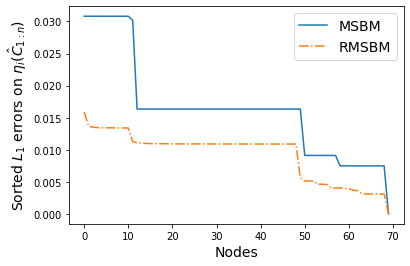

In [ ]:
cum_plugin = np.sort(np.abs(link_probas_optimal-link_probas_plugin))[::-1]
cum_robust = np.sort(np.abs(link_probas_optimal-link_probas_robust))[::-1]
plt.plot(cum_plugin, label='MSBM')
plt.plot(cum_robust,linestyle='-.', label='RMSBM')
plt.legend(fontsize=14)
plt.xlabel('Nodes', fontsize=14)
plt.ylabel('Sorted $L_1$ errors on $\eta_i(\hat{ C}_{1:n})$', fontsize=14)
plt.savefig('posterior_proba2.png')

# 4) Hypothesis Test

##### /!\ To run this code, you must have first run on a cluster the script **script_hypothesis_test.py** with an array job.

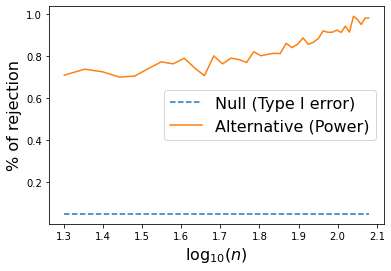

In [ ]:
nb_jobs = 50
list_n = [10*i for i in range(3,15)]
pvaluesiid = np.zeros((14,nb_jobs))
pvaluesmarkov = np.zeros((14,nb_jobs))
count = 0
for i in range(0,nb_jobs):
    piid = np.load('pvalue_iid'+str(i)+'_K4.npy')
    plat = np.load('pvalue_markov'+str(i)+'_K4.npy')
    pvaluesiid[:,count] = piid
    pvaluesmarkov[:,count] = plat
    count += 1

pvaluesmarkov = pvaluesmarkov[:,:count]
pvaluesiid = pvaluesiid[:,:count]   
rejet_iid = []
rejet_markov = []
for i in range(len(list_n)):
    sorted_piid = np.sort(pvaluesiid[i,:])
    limitechi2 = sorted_piid[int(0.05 * len(sorted_piid))]
    rejet_iid.append(0.05 * len(sorted_piid)/len(sorted_piid))
    rejet_markov.append(np.mean( pvaluesmarkov[i,:] < limitechi2 ))

plt.plot(np.log10(list_n), rejet_iid, label='Null (Type I error)', linestyle='--')
plt.plot(np.log10(list_n), rejet_markov, label='Alternative (Power)')
plt.xlabel('$\log_{10}(n)$',fontsize=16)
plt.ylabel('% of rejection',fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('hypo_testing_msbm.png',dpi=250)

# 5) Application to real data

In [4]:
import pandas as pd
from math import sin, cos, sqrt, atan2, radians

## PLEASE DOWNLOAD THE DATA FROM : https://www.datarepository.movebank.org/handle/10255/move.747

df = pd.read_csv('White-fronted goose full year tracks 2006-2010 Alterra IWWR-argos.csv')

In [7]:
dfmat = df[df['individual-local-identifier']==72417]

# WE COMPUTE THE TRANSITION MATRIX P AND THE CONNECTION MATRIX Q


def compute_distance(lat1,lon1,lat2,lon2):
  # approximate radius of earth in km

        R = 6373.0

        lat1 = radians(np.float(lat1))
        lon1 = radians(np.float(lon1))
        lat2 = radians(np.float(lat2))
        lon2 = radians(np.float(lon2))
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        return distance

threshold = 900
K = 7
trueP = np.zeros((K,K))
trueQ = np.zeros((K,K))
approx_effectifs = np.zeros(K)
ind2state = ['0','1','B','A','2','3','Z']
state2ind = {state:i for i,state in enumerate(ind2state)}
for i in range(dfmat.shape[0]-1):
    approx_effectifs[state2ind[dfmat.iloc[i]['argos:lc']]] += 1

for i in range(dfmat.shape[0]-1):
    trueP[state2ind[dfmat.iloc[i]['argos:lc']],state2ind[dfmat.iloc[i+1]['argos:lc']]] += 1
for i in range(dfmat.shape[0]-1):
    linei = dfmat.iloc[i]
    lat1 = linei['location-lat']
    lon1 = linei['location-long']
    for j in range(dfmat.shape[0]-1):
        linej = dfmat.iloc[j]
        lat2 = linej['location-lat']
        lon2 = linej['location-long']
        trueQ[state2ind[linei['argos:lc']],state2ind[linej['argos:lc']]] += compute_distance(lat1,lon1,lat2,lon2)<=threshold

for k in range(K):
			for l in range(K):
				  trueQ[k,l] /= max(1,approx_effectifs[k]*approx_effectifs[l])
# We focus on the animal with ID 72417
dfind = df[df['individual-local-identifier']==72417]
# We focus on four clusters
dfind = dfind[dfind['argos:lc'].isin(['B','0','1','A'])]
trueP = trueP[:4,:]
trueP = trueP[:,:4]
for i in range(4):
    trueP[i,:] /= np.sum(trueP[i,:])
trueQ = trueQ[:4,:]
trueQ = trueQ[:,:4]

In [8]:
# WE BUILD THE ADJACENCY MATRIX

dfind = dfind.iloc[:70]
clusters = [ state2ind[dfind.iloc[i]['argos:lc']] for i in range(dfind.shape[0])]
n = dfind.shape[0]
Theta = np.zeros((n,n))
X = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1,n):
        c1 = state2ind[dfind.iloc[i]['argos:lc']]
        c2 = state2ind[dfind.iloc[j]['argos:lc']]
        lat1 = dfind.iloc[i]['location-lat']
        lat2 = dfind.iloc[j]['location-lat']
        lon1 = dfind.iloc[i]['location-long']
        lon2 = dfind.iloc[j]['location-long']
        X[i,j] = compute_distance(lat1, lon1, lat2, lon2) <= threshold
        X[j,i] = X[i,j]

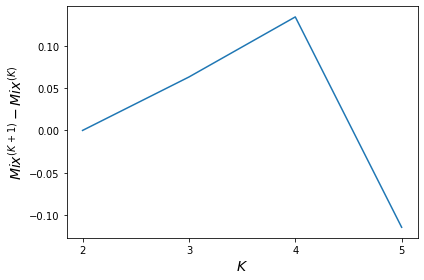

In [9]:
# ESTIMATION OF THE NUMBER OF CLUSTERS

np.random.seed(4)
scores = []
for K in [2,3,4,5,6]:
    Ggap = SBM(n, K, framework='markov', X=X, save_B_matrices=False)
    ini, gamma, P, O = Ggap.BaumWelch(n-3, n-2, 0, 20, eps = 1e-2, K=K)
    score = np.max(-2*np.eye(K)+O+O.T)
    scores.append(score)

from matplotlib.ticker import MaxNLocator
ls = []
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for k in range(len(scores)-1):
    ls.append(scores[k+1]-scores[k])
ax.plot([k for k in range(2,6)], ls)
ax.set_ylabel('$Mix^{(K+1)}-Mix^{(K)}$',fontsize=14)
ax.set_xlabel('$K$',fontsize=14)
plt.tight_layout()
plt.savefig('inferring_K_real.png',dpi=250)

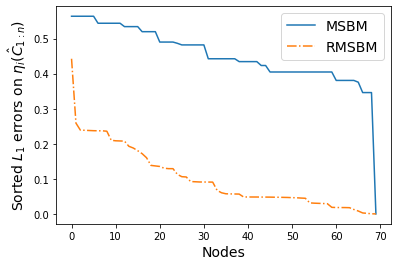

In [10]:
# L1 ERRORS ON THE POSTERIOR PROBABILITIES

n = 70
K = 4
G = SBM(n, K, framework='markov', X=X)
G.clusters = clusters
G.estimate_partition()
G.estimate_parameters()

def link_prediction_plugin():
    link_probas = np.zeros(G.n)
    compteur = np.zeros(G.K)
    for i in range(n-2):
        link_probas[i] += np.sum(G.approx_P[G.clusters_approx[G.n-1],:] * G.approx_Q[G.clusters_approx[i],:])
    return link_probas
        
def link_prediction_robust():
    ini, gamma, P, O = G.BaumWelch(G.n-2,G.n-1, 0 , 40)
    alpha = G.forward(ini, G.approx_P, O, G.n-2, G.n-1, 0, G.clusters_approx)
    beta = G.backward(G.approx_P, O, G.n-2, G.n-1, 0, G.clusters_approx)
    Y = G.clusters_approx
    link_probas = np.zeros(G.n)
    compteur = np.zeros(G.K)
    chi = np.zeros((G.K,G.K))
    for c in range(G.K):
        for cb in range(G.K):
            chi[c,cb] = G.approx_P[c,cb]*O[cb,G.clusters_approx[G.n-1]]
    for i in range(n-2,-1,-1):
        temp = np.zeros((G.K,G.K, G.K))
        for k in range(G.K):
            for ci in range(G.K):
                for cn in range(G.K):
                    temp[ci,cn,k] = alpha[ci,i] * chi[ci,cn] * beta[cn,G.n-1]
            temp[:,:,k] /= np.sum(temp[:,:,k])
        for k in range(G.K):
            for ci in range(G.K):
                for cn in range(G.K):
                    temp[ci,cn,k] *= G.approx_Q[ci,k] * G.approx_P[cn,k]
        link_probas[i] = np.sum(temp)
        chinew = np.zeros((G.K,G.K))
        for c in range(G.K):
            for cb in range(G.K):
                chinew[c,cb] = np.sum(G.approx_P[c,:]*(O[:,Y[i]] + chi[:,cb]))
        chi = np.copy(chinew)
    return link_probas

def link_prediction_optimal():
    link_probas = np.zeros(G.n)
    compteur = np.zeros(G.K)
    for i in range(n-1):
        link_probas[i] += np.sum(trueP[G.clusters[G.n-1],:] * trueQ[G.clusters[i],:])
    return link_probas

link_probas_plugin = link_prediction_plugin()
link_probas_robust = link_prediction_robust()
link_probas_optimal = link_prediction_optimal()

cum_plugin = np.sort(np.abs(link_probas_optimal-link_probas_plugin))[::-1]
cum_robust = np.sort(np.abs(link_probas_optimal-link_probas_robust))[::-1]
plt.plot(cum_plugin, label='MSBM')
plt.plot(cum_robust,linestyle='-.', label='RMSBM')
plt.legend(fontsize=14)
plt.xlabel('Nodes', fontsize=14)
plt.ylabel('Sorted $L_1$ errors on $\eta_i(\hat{ C}_{1:n})$', fontsize=14)
plt.savefig('posterior_proba2_real.png')

# 6) Study of the SDP algorithm for clustering from Giraud and Verzelen when dealing with some small clusters

In [ ]:
import markovianSBM
from markovianSBM.SBM import SBM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats
import os
import networkx as nx

np.random.seed(4)
n = 80
K = 2
scores = []
liste = [0.4,0.35,0.3,0.2,0.1,0.05,0.04,0.03,0.02,0.01]
error = np.zeros(len(liste))
for l,small in enumerate(liste):
    pi = [small, 1-small]
    a = 0.5
    b = pi[0]*(1-a)/pi[1]
    P = np.array([pi,pi])
    #P = np.array([[a,1-a],[b,1-b]])

    Q =  (np.diag(0.75 * np.ones(K)) + 0.05 * np.ones((K,K))) * np.log(G.n)/G.n
    G = SBM(n, 2, framework='markov', P=P, Q=Q, save_B_matrices=True)
    G.estimate_partition()
    G.estimate_parameters()

    for i in range(G.n):
        if G.clusters_approx[i]==0:
            error[l] += 1 / G.effectifs[0]

In [ ]:
plt.scatter(liste[:-1],error[:-1],marker='x')
plt.xlabel('$\pi_1 = \\gamma$', fontsize=15)
plt.ylabel('$\\frac{|\widehat G_1|}{|G_1|}$', fontsize=20)
plt.axhline(y=1, xmin=0, xmax=1,linestyle='--',color='black')
plt.savefig('overestimation_small_clusters.png',dpi=150, bbox_inches="tight")